In [ ]:
import firedrake
import functools
import sympy
import icepack
import numpy as np
import scipy
from icepack.utilities import depth_average, lift3d

In [ ]:
Lx, Ly = 20e3, 20e3
nx, ny = 48, 48

mesh2d = firedrake.RectangleMesh(nx, ny, Lx, Ly)
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='DG', vdegree=0)
Q3D = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='GL', vdegree=5)
V = firedrake.VectorFunctionSpace(mesh, dim=2, family='CG', degree=2, vfamily='GL', vdegree=5)
# note we should call the families in the vertical velocity solver.

x, y, ζ = firedrake.SpatialCoordinate(mesh)

u_inflow=1.0
v_inflow=2.0
mu=.003
mv=.001

b=firedrake.interpolate(firedrake.Constant(0.0),Q)
s=firedrake.interpolate(firedrake.Constant(1000.0),Q)
h = firedrake.interpolate(s-b,Q)
u = firedrake.interpolate(firedrake.as_vector((mu*x+u_inflow,mv*y+v_inflow)),V)

m=0.0

def analytic_vertical_velocity(h,ζ,mu,mv,m,Q3D):
    return firedrake.interpolate(firedrake.Constant(m)-(firedrake.Constant(mu+mv)*h*ζ),Q3D)

In [3]:
def _legendre(n, ζ):
    return sympy.functions.special.polynomials.legendre(n,2 * ζ -1)


def weight(n,ζ):
    norm=(1/sympy.integrate(_legendre(n,ζ)**2,(ζ,0,1)))**.5
    return sympy.lambdify(ζ,norm*_legendre(n,ζ),'numpy')

def coefficient(n,q3d,ζ,ζsym,Q):
    """
    n : int
    q3d : firedrake.Function
    """
    a_n=depth_average(q3d,weight=weight(n,ζsym)(ζ))
    a_n3d=lift3d(a_n,Q)
    return a_n3d

@functools.lru_cache(maxsize=None)
def recurrance_relation(n,ζ):
    if n>0:
        return sympy.lambdify(ζ,(1/(2*(2*n+1)))*(_legendre(n+1,ζ)-_legendre(n-1,ζ)),'numpy')
    elif n==0:
        return sympy.lambdify(ζ,1/2,'numpy')
    if n<0:
        print('error')

def vertical_integrate(q3d,h):
    """
    q3d : firedrake.Function
    """
    Q=h.function_space()
    mesh=Q.mesh()
    W=q3d.function_space()
    x,y,ζ=firedrake.SpatialCoordinate(mesh)
    xdegree_q3d,zdegree_q3d=q3d.ufl_element().degree()

    ζsym=sympy.symbols("ζsym")
    w3d=firedrake.Function(W)
    w3d=sum([coefficient(k,q3d,ζ,ζsym,Q) * h * recurrance_relation(k,ζsym)(ζ) for k in range(1,zdegree_q3d)])
    return firedrake.interpolate(w3d,W)

def vertical_velocity(u,h,m=0.0):
    """
    u : firedrake.Function
    h : firedrake.Function
    m : terrain following ice base velocity (melt rate/accretion rate)
    """
    Q = h.function_space()
    mesh=Q.mesh()
    xdegree_u, zdegree_u = u.ufl_element().degree()
    W = firedrake.FunctionSpace(mesh,family='CG',degree=xdegree_u,vfamily='GL',vdegree=zdegree_u)
    u_div=firedrake.interpolate(u[0].dx(0)+u[1].dx(1),W)
    return firedrake.interpolate(m-vertical_integrate(u_div,h),W)

In [4]:
w=vertical_velocity(u,h,m=0.0)

w_analytic=analytic_vertical_velocity(h,ζ,mu,mv,m,Q3D)

# vertical velocity

In [5]:
xdegree_u, zdegree_u = u.ufl_element().degree()
W = firedrake.FunctionSpace(mesh,family='CG',degree=xdegree_u,vfamily='GL',vdegree=zdegree_u)
w=vertical_velocity(u,h)

In [6]:
ζsym=sympy.symbols("ζsym")
f0=recurrance_relation(0,ζsym)
f1=recurrance_relation(1,ζsym)
f2=recurrance_relation(2,ζsym)
f3=recurrance_relation(3,ζsym)
f4=recurrance_relation(4,ζsym)

In [7]:
order_0=firedrake.interpolate(h*f0(ζ),W)
order_1=firedrake.interpolate(h*f1(ζ),W)
order_2=firedrake.interpolate(h*f2(ζ),W)
order_3=firedrake.interpolate(h*f3(ζ),W)
order_4=firedrake.interpolate(h*f4(ζ),W)

In [8]:
u_div=firedrake.interpolate(u[0].dx(0)+u[1].dx(1),W)

In [18]:
np.min(order_0.dat.data)
np.min(order_1.dat.data)
np.min(order_2.dat.data)
np.min(order_1.dat.data)

-235.76522100824815

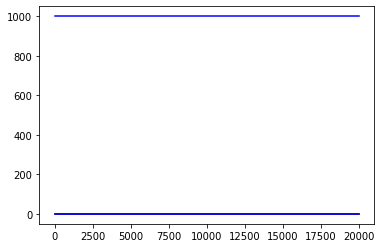

In [10]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


xs = np.array([(Lx * k / nx, 0, .5) for k in range(nx + 1)])
ss = np.array(s.at(xs, tolerance=1e-10))
hs = np.array(h.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0], bs, color='black')
axes.plot(xs[:, 0], ss - hs, color='blue')
axes.plot(xs[:, 0], ss, color='blue')
plt.savefig('fig01.png')



In [ ]:
nz=20

xz = np.array([(Lx * k / nx, Ly/2.0, i)  for k in range(nx + 1) for i in np.arange(0.0,1.0,1.0/nz)])
wM= np.array(w.at(xz, tolerance=1e-10))
waM= np.array(w_analytic.at(xz, tolerance=1e-10))
udivM= np.array(u_div.at(xz, tolerance=1e-10))
udivM = np.reshape(udivM,(49,nz));
wM=np.reshape(wM,(49,nz));
waM=np.reshape(waM,(49,nz));

xz=np.reshape(xz,(49,nz,3));
hz=np.reshape(np.repeat(hs,nz),(49,nz));
hz=np.multiply(xz[:,:,2],hz,);

fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(np.min(wM-waM),np.max(wM-waM))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(wM[:,i]-waM[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity difference (numerical-analytic).$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.savefig('fig02.png')

fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(np.min(wM),np.max(wM))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(wM[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity numerical.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.savefig('fig03.png')


fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(-.4,0.0)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(waM[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity analytic.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.savefig('fig04.png')

fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(np.min(udivM),np.max(udivM))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(udivM[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'divergence of u.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.savefig('fig05.png')



In [15]:
print(coefficient(0,u_div,ζ,ζsym,Q).dat.data[0])
print(coefficient(1,u_div,ζ,ζsym,Q).dat.data[0])
print(coefficient(2,u_div,ζ,ζsym,Q).dat.data[0])
print(coefficient(3,u_div,ζ,ζsym,Q).dat.data[0])
print(coefficient(4,u_div,ζ,ζsym,Q).dat.data[0])

0.003999999999999987
-2.145398361401932e-17
8.759292483883158e-18
1.9646190886925577e-17
6.12648653359441e-18


In [16]:
xz = np.array([(Lx * k / nx, Ly/2.0, i)  for k in range(nx + 1) for i in np.arange(0.0,1.0,1.0/nz)])
o0= np.array(order_0.at(xz, tolerance=1e-10))
o1= np.array(order_1.at(xz, tolerance=1e-10))
o2= np.array(order_2.at(xz, tolerance=1e-10))
o3= np.array(order_3.at(xz, tolerance=1e-10))
o4= np.array(order_4.at(xz, tolerance=1e-10))
o0=np.reshape(o0,(49,nz));
o1=np.reshape(o1,(49,nz));
o2=np.reshape(o2,(49,nz));
o3=np.reshape(o3,(49,nz));
o4=np.reshape(o4,(49,nz));

xz=np.reshape(xz,(49,nz,3));

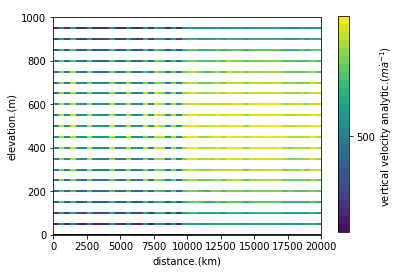

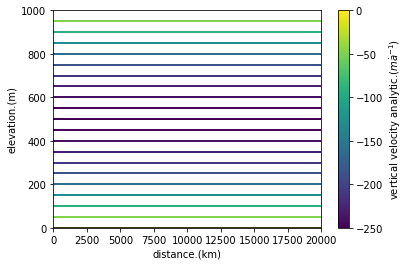

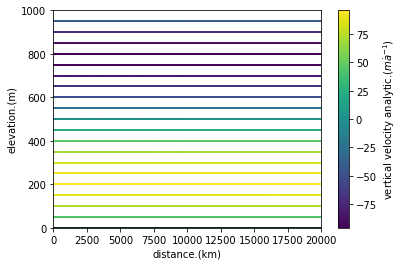

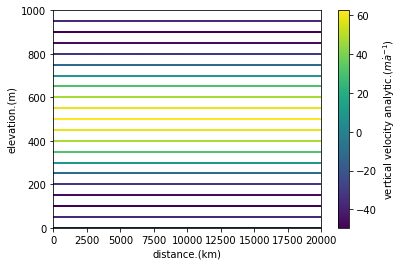

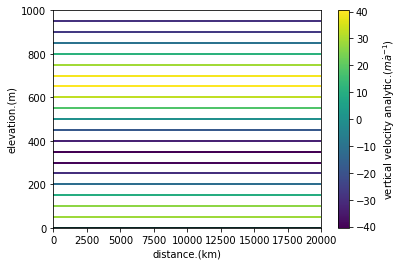

In [17]:


fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(np.min(o0),np.max(o0))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(o0[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity analytic.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()



fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(np.min(o1),np.max(o1))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(o1[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity analytic.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()



fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(np.min(o2),np.max(o2))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(o2[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity analytic.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()



fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(np.min(o3),np.max(o3))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(o3[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity analytic.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()



fig, axs = plt.subplots()
for i in range(nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(bs+hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(np.min(o4),np.max(o4))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(o4[:,i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity analytic.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()


In [101]:
(1/sympy.integrate(_legendre(4,ζsym)**2,(ζsym,0,1)))**.5*_legendre(4,ζsym)

13.125*(2*ζsym - 1)**4 - 11.25*(2*ζsym - 1)**2 + 1.125

In [86]:
np.sqrt(3)

1.7320508075688772